In [1]:
import qiskit.visualization
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
from random import randint

In [2]:
def sim(circuit, simulator, shots,x_val,y_val,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simGetCounts(circuit, simulator, shots,), title=rf" {x_val}+{y_val} mod {N} = ${(x_val+y_val)%N }_{{10}}$ = ${((x_val+y_val)%N):0{n_qubits}b}_{{2}}$ "))

def simGetCounts(circuit, simulator, shots):
    return simulator.run(qiskit.transpile(circuit, simulator),shots=shots).result().get_counts(0)

In [3]:
def qft_adder(y_val,x):
    """
        assuming the first Quantum register is the x+1-register, and the second  is c1, third is c2
    """
    qc = QuantumCircuit(*x,name="qftAdd")
    # Apply QFT 
    qft = QFT(qc.num_qubits, do_swaps=False)
    qc.append(qft,qc.qubits[:] )
    
    # Apply controlled phase rotations
    for i in range(qc.num_qubits):
            theta = 2 * np.pi*y_val / (2 ** (i + 1))
            qc.p(theta, qc.qubits[i])
    # Apply inverse QFT 
    iqft = QFT(qc.num_qubits, do_swaps=False).inverse()
    qc.append(iqft, qc.qubits[:])
    
    return qc.to_instruction()

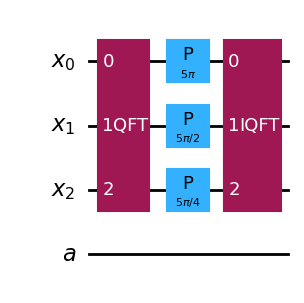

In [4]:
x = QuantumRegister(3,"x")
a = QuantumRegister(1,"a")
c1 = ClassicalRegister(1,"c1")
qc = QuantumCircuit(*[x,a])
qc.append(qft_adder(5,[x]),x)
qc.decompose().draw('mpl')

In [4]:
def Cqft_adder(y_val,c1,x):
    """
        assuming the first Quantum register is the x+1-register, and the second  is c1, third is c2
    """

    qc = QuantumCircuit(x,c1 ,name="CqftAdd")
    # Apply QFT 
    qft = QFT(qc.num_qubits -len(c1), do_swaps=False)
    qc.append(qft,qc.qubits[:-1] )
    
    # Apply controlled phase rotations
    for i in range(qc.num_qubits -len(c1)):
            theta = 2 * np.pi*y_val / (2 ** (i + 1))
            qc.cp(theta,c1[0], qc.qubits[i])
    # Apply inverse QFT 
    iqft = QFT(qc.num_qubits -len(c1), do_swaps=False).inverse()
    qc.append(iqft, qc.qubits[:-1])
    
    return qc.to_instruction()

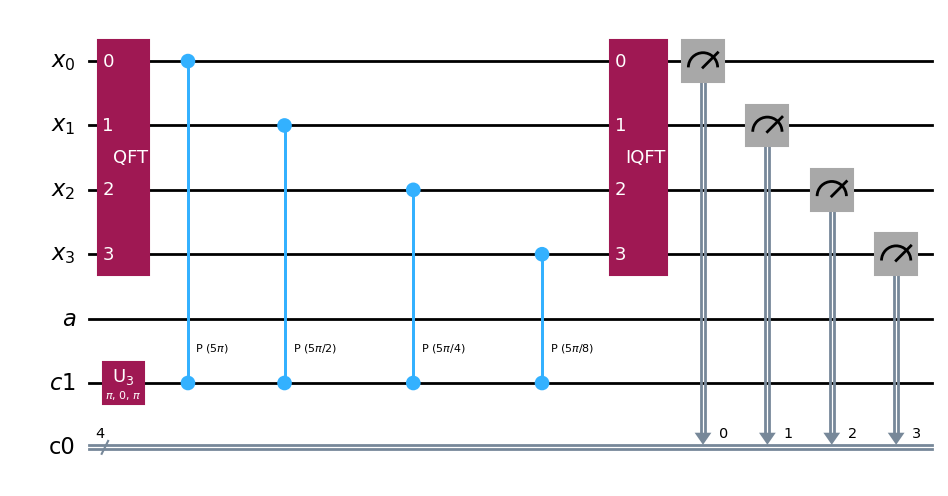

In [6]:
x = QuantumRegister(4,"x")
a = QuantumRegister(1,"a")
c1 = QuantumRegister(1,"c1")
clss = ClassicalRegister(4)
qc = QuantumCircuit(x,a,c1,clss)
qc.x(c1)
qc.append(Cqft_adder(5,c1,x),[*x,*c1])
qc.measure(x[:],clss[:])
qc.decompose().draw('mpl')

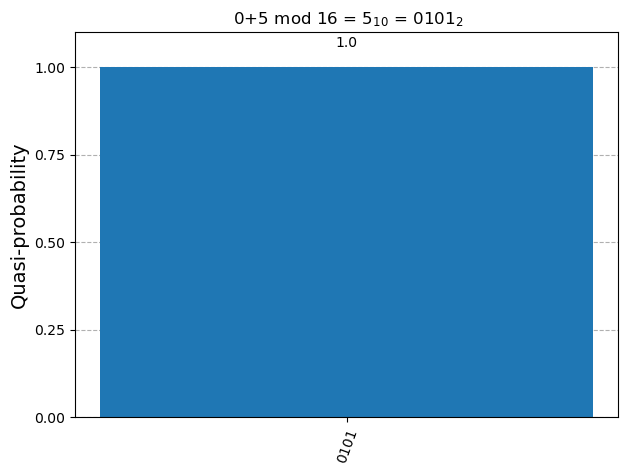

In [7]:
sim(qc,AerSimulator(),1000,0,5,2**4,4)

In [5]:
def isless( y_val, a,c1,x):
    qc = QuantumCircuit(x,a,c1,name="isLess")
    qc.append(qft_adder(-y_val,[x,a]),[*x,a])
    qc.cx(a,c1)
    qc.append(qft_adder( +y_val,[x,a]),[*x,a])
    return qc.to_instruction()


In [9]:
x = QuantumRegister(4,"x")
a = QuantumRegister(1,"a")
c1 = QuantumRegister(1,"c1")
clss = ClassicalRegister(4)
qc = QuantumCircuit(x,a,c1,clss)
for i in range(4):
        if (3 & (1 << i)):
            qc.x(qc.qubits[i])
qc.append(isless(4,a,c1,x),[*x,*a,*c1])
qc.measure(c1[:],clss[:])
qc.decompose().draw('mpl')

CircuitError: 'register name "c1" already exists'

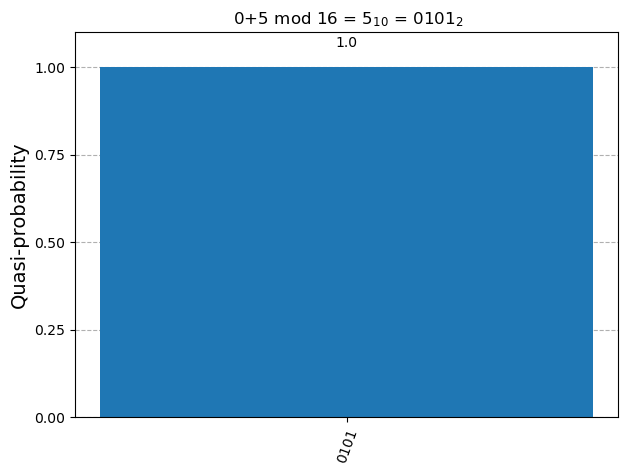

In [10]:
sim(qc,AerSimulator(),1000,0,5,2**4,4)

In [6]:
def modNWithoutCircuit(x_val,N,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    c = QuantumRegister(1,'c1')
    clss_c1 = ClassicalRegister(1,'class_c')
    clss = ClassicalRegister(n_qubits)  # Classical bit to store the c measurement 
    qc = QuantumCircuit(x, a, c,clss,clss_c1,name ="x+y mod N")
    for i in range(n_qubits):
        if (x_val & (1 << i)):
            qc.x(qc.qubits[i])
    qc.append(isless(N,a,c,x),[*x,*a,*c])
        # qc.x(x)
    qc.measure(c[0],clss_c1[0])
    with qc.while_loop((clss_c1[0],0)):
        qc.append(qft_adder(-N,[x]),x)
        qc.append(isless(N,a,c,x),[*x,*a,*c])
        qc.measure(c[0],clss_c1[0])
    qc.measure(x,clss)

    
    return qc

In [7]:
def modN(N,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    c = QuantumRegister(1,'c1')
    clss_c1 = ClassicalRegister(1,'class_c') 
    qc = QuantumCircuit(x, a, c,clss_c1,name ="x+y mod N")
    qc.append(isless(N,a,c,x),[*x,*a,*c])
        # qc.x(x)
    qc.measure(c[0],clss_c1[0])
    with qc.while_loop((clss_c1[0],0)):
        qc.append(qft_adder(-N,[x]),x)
        qc.append(isless(N,a,c,x),[*x,*a,*c])
        qc.measure(c[0],clss_c1[0])
    # qc.measure(x,clss)

    
    return qc

In [21]:
xval=15
Nval=7
nval=5

In [56]:
print(xval,Nval,nval)

16 7 5


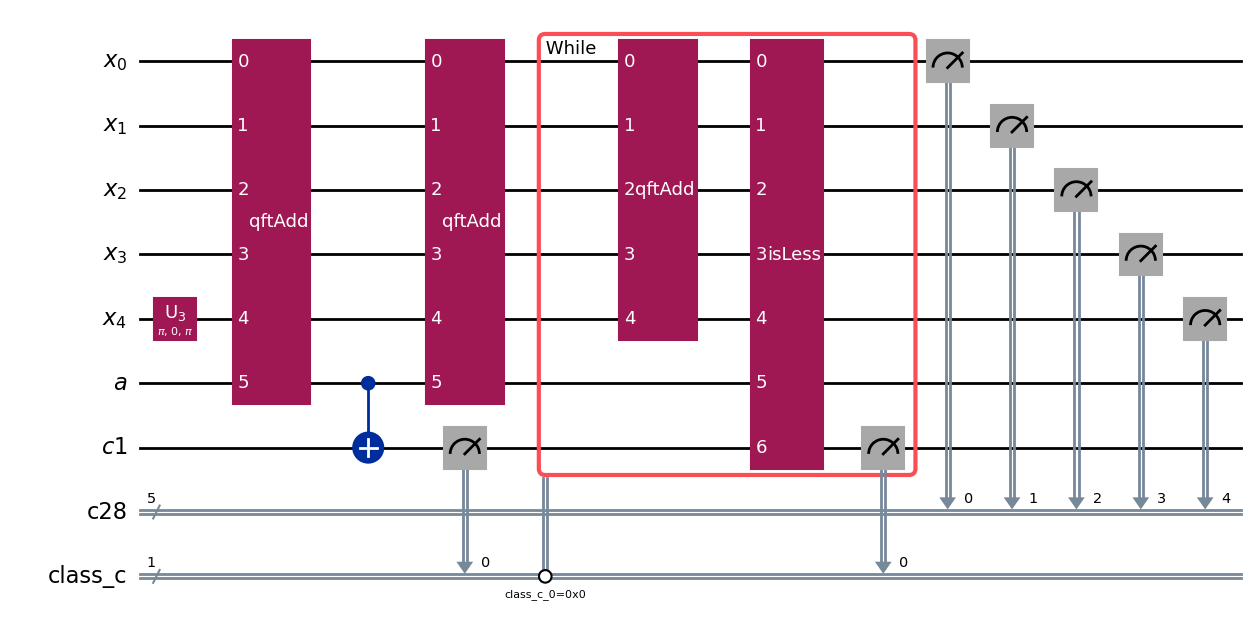

In [57]:
qc = modNWithoutCircuit(xval,Nval,nval)

qc.decompose().draw('mpl')

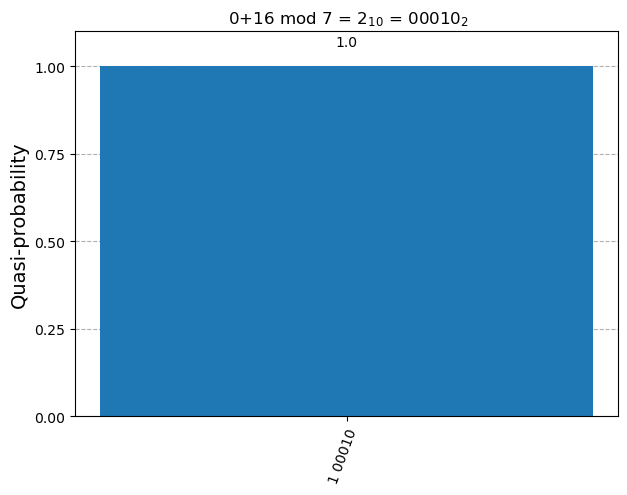

In [58]:
sim(qc,AerSimulator(),100,0,xval,Nval,nval)

In [59]:
num =int(list(simGetCounts(qc,AerSimulator(),100))[0][-nval:],2)


In [31]:
def get_circuit(x_val,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    a1 = QuantumRegister(1,'a1')
    a2 = QuantumRegister(1,'a2')
    c1 = QuantumRegister(1,'cnt')
    c2 = QuantumRegister(1,'cnt1')
    c3 = QuantumRegister(1,'cnt2')
    clss_c1 = ClassicalRegister(1,'class_c')
    clss_c2 = ClassicalRegister(1,'class_c2')
    clss_c3 = ClassicalRegister(1,'class_c3')
    clb = ClassicalRegister(n_qubits)
    qc = QuantumCircuit(x,a,a1,a2,c1,c2,c3,clb,clss_c1,clss_c2,clss_c3)
    for i in range(n_qubits):
        if (x_val & (1 << i)):
            qc.x(qc.qubits[i])
    return qc

In [45]:
def addmodN(y_val,N,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    a1 = QuantumRegister(1,'a1')
    a2 = QuantumRegister(1,'a2')
    c1 = QuantumRegister(1,'cnt')  
    c2 = QuantumRegister(1,'cnt1')  
    c3 = QuantumRegister(1,'cnt2')  
    clss_c1 = ClassicalRegister(1,'class_c')
    clss_c2 = ClassicalRegister(1,'class_c2')
    clss_c3 = ClassicalRegister(1,'class_c3')
    qc = QuantumCircuit(x, a,a1,a2, c1,c2,c3,clss_c1,clss_c2,clss_c3,name ="x+y mod N")
    qc =qc.compose(modN(N,n_qubits),[*x,*a1,*c2],clss_c2)

    # without y mod N this code will work only for x+y<2N
    n_qubits_y = int(np.ceil(np.log2(y_val)+1))
    qcFory = modNWithoutCircuit(y_val,N,n_qubits_y)
    y_val = int(list(simGetCounts(qcFory,AerSimulator(),100))[0][-n_qubits:],2)
    qc.append(isless(N-y_val,a,c1,x),[*x,*a,*c1])
    qc.append(qft_adder(y_val,[x]),x)
    qc.x(c1)
    qc.append(Cqft_adder(-N, c1,x), [*x,*c1])

    qc= qc.compose(modN(N,n_qubits),[*x,*a2,*c3],clss_c2)
    
    return qc

In [51]:
x_val =13
y_val = 7
N_val=7
n_qubits = int(np.ceil(np.log2(x_val)+1))

In [52]:
n_qubits_y = int(np.ceil(np.log2(y_val)+1))
qcFory = modNWithoutCircuit(y_val,N_val,n_qubits_y)
int(list(simGetCounts(qcFory,AerSimulator(),100))[0][-n_qubits:],2)

0

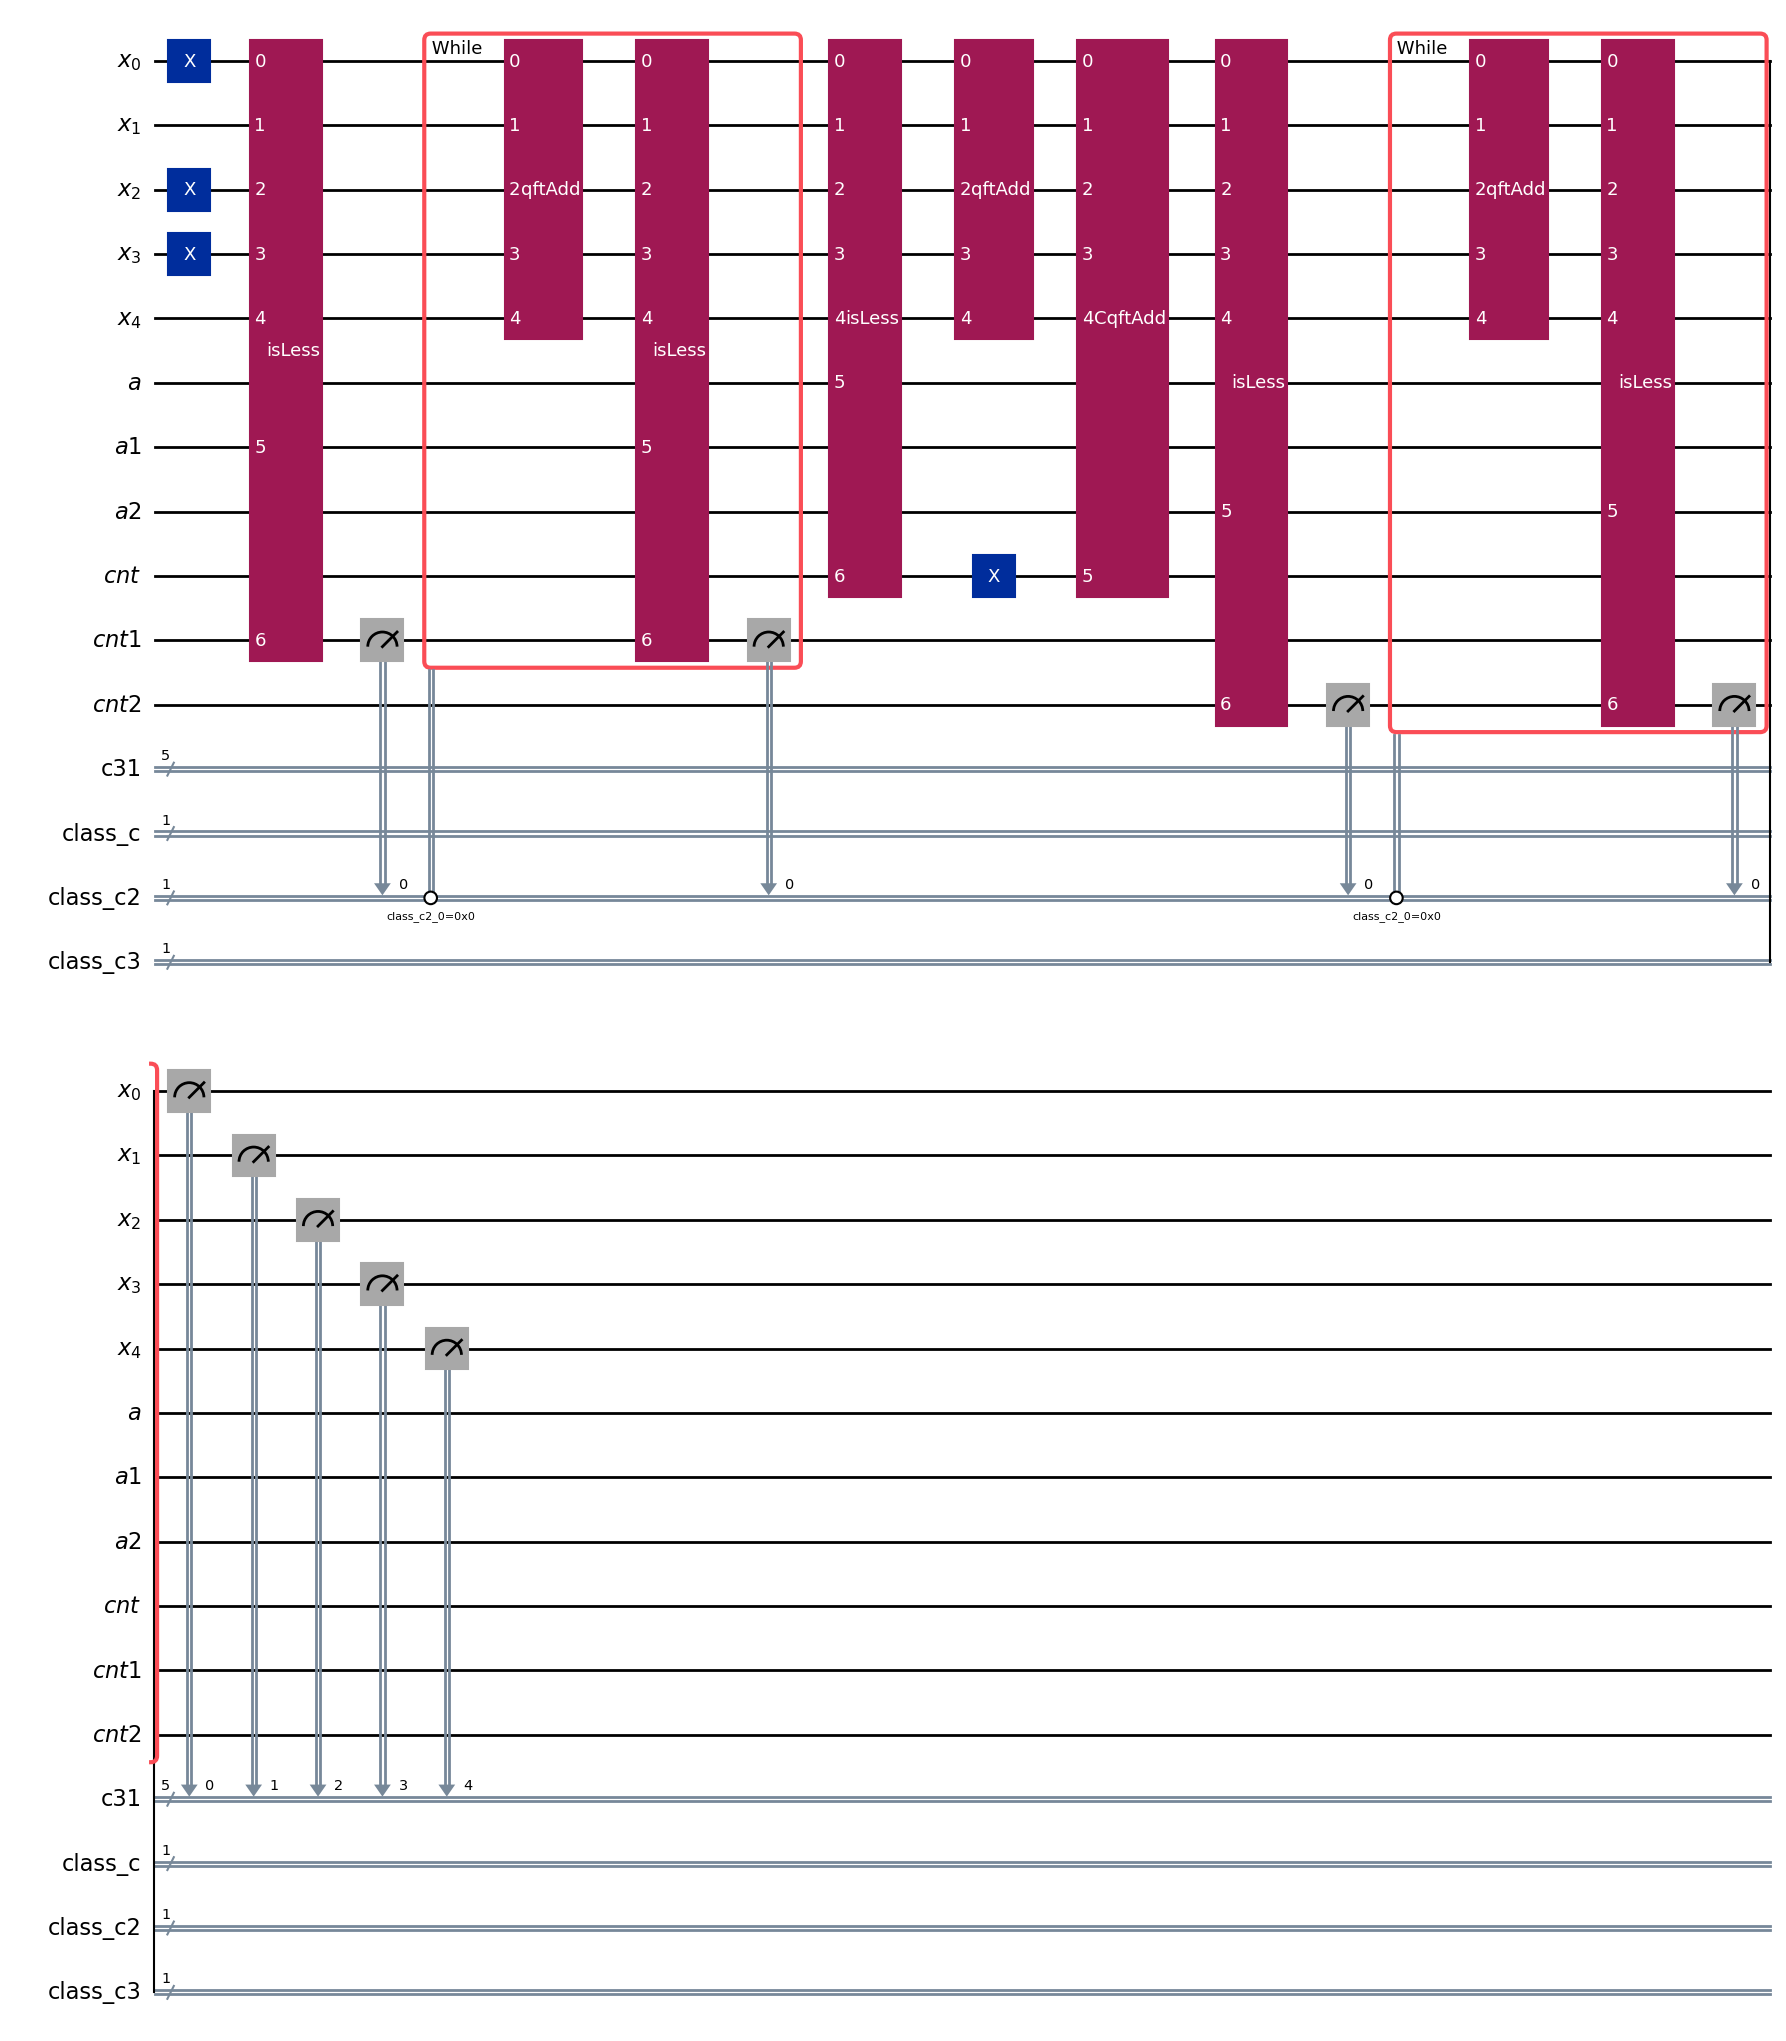

In [53]:
circuit = get_circuit(x_val,n_qubits)
circuit.compose(addmodN(y_val,N=N_val,n_qubits=n_qubits),circuit.qubits[:],[*circuit.cregs[1],*circuit.cregs[2],*circuit.cregs[3]],inplace=True)

circuit.measure(circuit.qregs[0][:],circuit.cregs[0][:n_qubits])
# circuit.measure(circuit.qregs[1][0],circuit.cregs[0][-1])
circuit.draw('mpl')

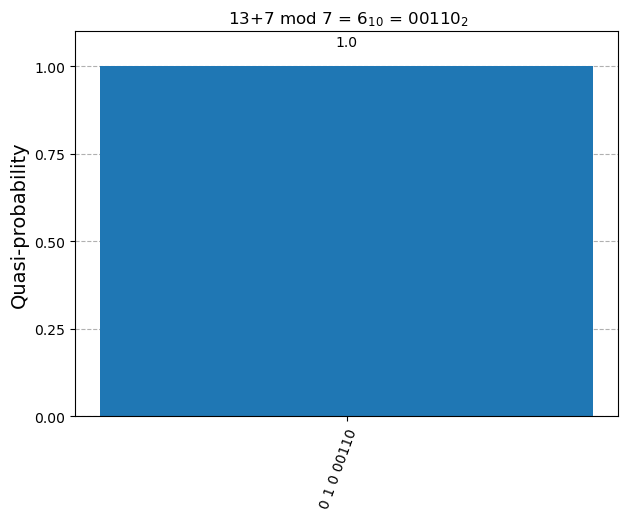

In [54]:
sim(circuit,AerSimulator(),1000,x_val,y_val,N_val,n_qubits)

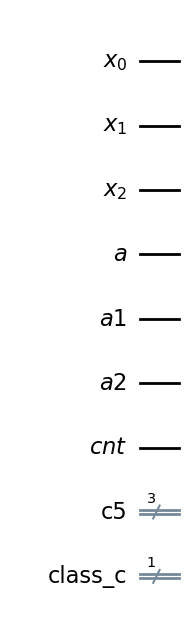

In [20]:
get_circuit(x_val,n_qubits).draw('mpl')

In [84]:
circ = QuantumCircuit(QuantumRegister(3),QuantumRegister(1),QuantumRegister(1),ClassicalRegister(4),ClassicalRegister(1,'class_c'),ClassicalRegister(1,'class_c1'))

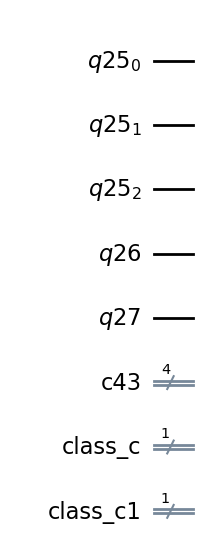

In [85]:
circ.draw('mpl')

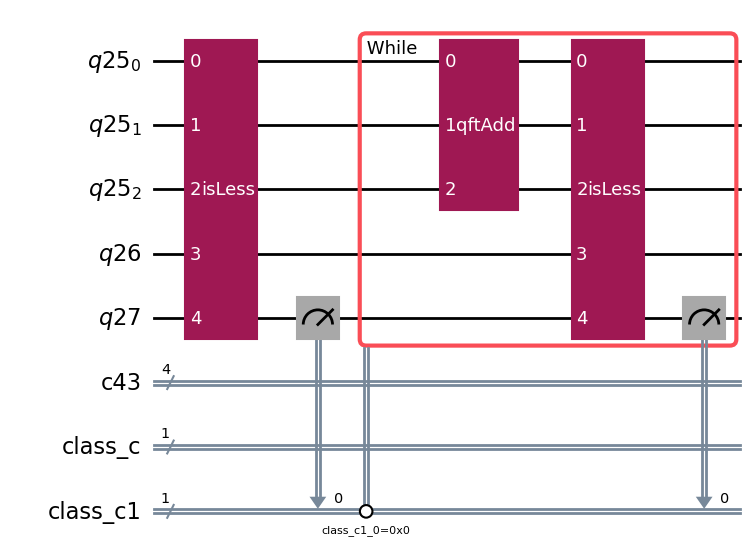

In [87]:
circ.compose(modN(5,3),circ.qubits[:],circ.cregs[2],front=True).draw("mpl")

In [ ]:
modN(5,3).draw('mpl')